In [1]:
import torch
flag = torch.cuda.is_available()
print(flag)

ngpu= 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

True
cuda:0
GeForce MX150


# LOG功能实现（Logger类）

In [2]:
import tensorflow as tf
import numpy as np
import scipy.misc 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x
    
from PIL import Image  


class Logger(object):
    
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
         # 创建一个指向log文件夹的summary writer
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        # 标量信息 日志
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""
        # 图像信息 日志
        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
#             scipy.misc.toimage(img).save(s, format="png")
            Image.fromarray(img).convert('RGB').save('{}.png'.format(i))

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)
        
    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""
        # 直方图信息 日志
        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()

In [3]:
# pip install torchvision==0.2.2
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision      # 数据库模块
import matplotlib.pyplot as plt

torch.manual_seed(1)    # reproducible

# 创建日志类，指定文件夹
logger = Logger('./logs')

# Hyper Parameters
EPOCH = 1           # 训练整批数据多少次, 为了节约时间, 我们只训练一次
BATCH_SIZE = 50
LR = 0.001          # 学习率
DOWNLOAD_MNIST = True  # 如果你已经下载好了mnist数据就写上 False


# Mnist 手写数字
train_data = torchvision.datasets.MNIST(
    root='./mnist/',    # 保存或者提取位置
    train=True,  # this is training data
    transform=torchvision.transforms.ToTensor(),    # 转换 PIL.Image or numpy.ndarray 成
                                                    # torch.FloatTensor (C x H x W), 训练的时候 normalize 成 [0.0, 1.0] 区间
    download=DOWNLOAD_MNIST,          # 没下载就下载, 下载了就不用再下了
)

In [4]:
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)

# 批训练 50samples, 1 channel, 28x28 (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# 为了节约时间, 我们测试时只测试前2000个
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_x = test_x.cuda()
test_y = test_data.test_labels[:2000].cuda()

D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


# CNN模型

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(  # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,      # input height
                out_channels=16,    # n_filters
                kernel_size=5,      # filter size
                stride=1,           # filter movement/step
                padding=2,      # 如果想要 con2d 出来的图片长宽没有变化, padding=(kernel_size-1)/2 当 stride=1
            ),      # output shape (16, 28, 28)
            nn.ReLU(),    # activation
            nn.MaxPool2d(kernel_size=2),    # 在 2x2 空间里向下采样, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(  # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),  # output shape (32, 14, 14)
            nn.ReLU(),  # activation
            nn.MaxPool2d(2),  # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)   # 展平多维的卷积图成 (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output,x

cnn = CNN().cuda()
# print(cnn)  # net architecture

# torch.device 屬性，這樣一來我們就可以更方便的指定模型和變量運行的設備, 
# nn.Module 調用.to(device)後它內部參數的數據類型會從torch.FloatTensor 變成torch.cuda.FloatTensor, torch.Tensor 
# 調用.to(device)方法後數據類型會從torch.*Tensor 變成torch.cuda.*Tensor

if torch.cuda.is_available():
    print("Using GPU")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn.to(device)

Using GPU


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

# 訓練

In [6]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)
    
plt.ion()

Epoch:  0 | train loss: 2.3105 | test accuracy: 0.06


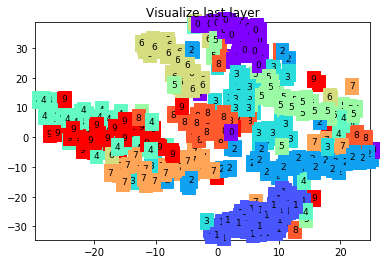

RuntimeError: CUDA error: out of memory

In [7]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss().cuda()

for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):

        # !!!!!!!! Change in here !!!!!!!!! #
        b_x = x.cuda()    # Tensor on GPU
        b_y = y.cuda()    # Tensor on GPU
        
#         images, labels = images.view(images.size(0), -1).to(device), labels.to(device)

        output = cnn(b_x)[0]
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 50 == 0:          
            test_output, last_layer = cnn(test_x)
            
            # !!!!!!!! Change in here !!!!!!!!! #
            pred_y = torch.max(test_output, 1)[1].cuda().data  # move the computation in GPU

            accuracy = torch.sum(pred_y == test_y).type(torch.FloatTensor) / test_y.size(0)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.2f' % accuracy)
            
            # 1. Log scalar values (scalar summary)
            # 日志输出标量信息（scalar summary）
            info = { 'loss': loss.item(), 'accuracy': accuracy.item() }

            for tag, value in info.items():
                logger.scalar_summary(tag, value, step)
            
            # 2. Log values and gradients of the parameters (histogram summary)
            # 日志输出参数值和梯度（histogram summary)
            for tag, value in cnn.named_parameters():
                tag = tag.replace('.', '/')
                logger.histo_summary(tag, value.data.cpu().numpy(), step+1)
                logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), step+1)
                
            # 3. Log training images (image summary)
            # 日志输出图像(image summary)
            info = { 'images': b_x.view(-1, 28, 28)[:10].cpu().numpy() }

            for tag, images in info.items():
                logger.image_summary(tag, images, step+1)
            
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.data.cpu().numpy()[:plot_only, :])
                labels = test_y.cpu().numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
                
#                 break
                
#     break

In [ ]:
test_output = cnn(test_x[:10])

# !!!!!!!! Change in here !!!!!!!!! #
pred_y = torch.max(test_output[0], 1)[1].cuda().data # move the computation in GPU

print(pred_y, 'prediction number')
print(test_y[:10], 'real number')